# Will train non-linear models for our completely cleaned data csv

In [1]:
from pathlib import Path
import pandas as pd


df = pd.read_csv('../datasets/price_datasets/complete_price_data_for_model.csv')
df.head()

,ZIPCODE,GROSS_AREA,LIVING_AREA,BED_RMS,FULL_BTH,HLF_BTH,NUM_PARKING,KITCHENS,FIREPLACES,KITCHEN_TYPE,HEAT_TYPE,AC_TYPE,TOTAL_VALUE
0,2128,3353.0,2202.0,6.0,3.0,0.0,3.0,3.0,0.0,3,-2,-1,719400.0
1,2128,3299.0,2307.0,3.0,3.0,0.0,0.0,3.0,0.0,3,1,2,744800.0
2,2128,3392.0,2268.0,5.0,3.0,2.0,0.0,3.0,0.0,3,-1,-1,730500.0
3,2128,3108.0,2028.0,5.0,3.0,0.0,0.0,3.0,0.0,3,-2,-1,667900.0
4,2128,3700.0,2546.0,6.0,3.0,2.0,0.0,2.0,0.0,2,-2,-1,714200.0


In [2]:
X = df.drop(columns=['TOTAL_VALUE'])
y = df['TOTAL_VALUE']

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [4]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

numeric_cols = [
    'GROSS_AREA', 'LIVING_AREA', 'BED_RMS', 'FULL_BTH', 'HLF_BTH',
    'NUM_PARKING', 'KITCHENS', 'FIREPLACES'
]

X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

In [5]:
import joblib

# Save StandardScaler
joblib.dump(scaler, "scaler_price_features.pkl")

# Save which columns were scaled
joblib.dump(numeric_cols, "scaler_numeric_columns.pkl")

print("Saved scaler_price_features.pkl and scaler_numeric_columns.pkl")

Saved scaler_price_features.pkl and scaler_numeric_columns.pkl


In [6]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

models = {
    "Linear Regression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.001),
    "Random Forest": RandomForestRegressor(n_estimators=500, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42)
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)
    results[name] = (rmse, r2)

results

{'Linear Regression': (np.float64(468954.05581962573), 0.4938026030200223),
 'Ridge': (np.float64(468954.0416174552), 0.49380263368017563),
 'Lasso': (np.float64(468954.0558036619), 0.49380260305448564),
 'Random Forest': (np.float64(99474.5562014905), 0.9772236915573),
 'Gradient Boosting': (np.float64(246241.42393752377), 0.8604333858422237)}

### This result tells us that linear models are not suitable for our dataset as expected, and Random Forest is our best model. It explains 97% of the variance in our price data.

In [7]:
rf_model = RandomForestRegressor(n_estimators=500, random_state=42)
rf_model.fit(X_train, y_train)

rf_preds = rf_model.predict(X_test)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_preds))
rf_r2 = r2_score(y_test, rf_preds)

print(f"Random Forest RMSE: {rf_rmse}, R2: {rf_r2}")

joblib.dump(rf_model, "best_price_model.pkl")
print("Saved best_price_model.pkl")


Random Forest RMSE: 99474.5562014905, R2: 0.9772236915573
Saved best_price_model.pkl


### Testing XGBoost and LightGBM models

In [13]:
%pip install -q xgboost lightgbm


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [8]:
import time
import numpy as np

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [9]:
xgb_model = XGBRegressor(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    n_jobs=-1
)

lgbm_model = LGBMRegressor(
    n_estimators=600,
    learning_rate=0.05,
    num_leaves=64,
    subsample=0.8,
    colsample_bytree=0.8
)

def time_and_evaluate(name, model, X_train, y_train, X_test, y_test):
    start = time.perf_counter()
    model.fit(X_train, y_train)
    end = time.perf_counter()

    preds = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)

    print(f"{name}")
    print(f"  Train time: {end - start:.3f} seconds")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  R²: {r2:.4f}")
    print("-" * 40)

# Call for each model
time_and_evaluate("XGBoost", xgb_model, X_train, y_train, X_test, y_test)
time_and_evaluate("LightGBM", lgbm_model, X_train, y_train, X_test, y_test)

XGBoost
  Train time: 1.437 seconds
  RMSE: 151333.00
  R²: 0.9473
----------------------------------------
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003166 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 631
[LightGBM] [Info] Number of data points in the train set: 279531, number of used features: 12
[LightGBM] [Info] Start training from score 763023.831682
LightGBM
  Train time: 5.440 seconds
  RMSE: 156241.55
  R²: 0.9438
----------------------------------------


In [17]:
time_and_evaluate("Random Forest", rf_model, X_train, y_train, X_test, y_test)

Random Forest
  Train time: 262.889 seconds
  RMSE: 99427.91
  R²: 0.9772
----------------------------------------


## Below is to ensure that Random Forest model doesn't take much time when running for a single data point

In [ ]:
sample_input = pd.DataFrame([{
    "ZIPCODE": 2134,
    "GROSS_AREA": 2500,
    "LIVING_AREA": 1800,
    "BED_RMS": 3,
    "FULL_BTH": 2,
    "HLF_BTH": 1,
    "NUM_PARKING": 2,
    "KITCHENS": 1,
    "FIREPLACES": 1,
    "KITCHEN_TYPE": 2,
    "HEAT_TYPE": 3,
    "AC_TYPE": 1
}])

In [11]:
sample_input[numeric_cols] = scaler.transform(sample_input[numeric_cols])

In [12]:
start = time.perf_counter()
prediction = rf_model.predict(sample_input)[0]
end = time.perf_counter()

print(f"Predicted Price: ${prediction:,.2f}")
print(f"Prediction Time: {end - start:.6f} seconds")

Predicted Price: $632,627.26
Prediction Time: 0.062998 seconds


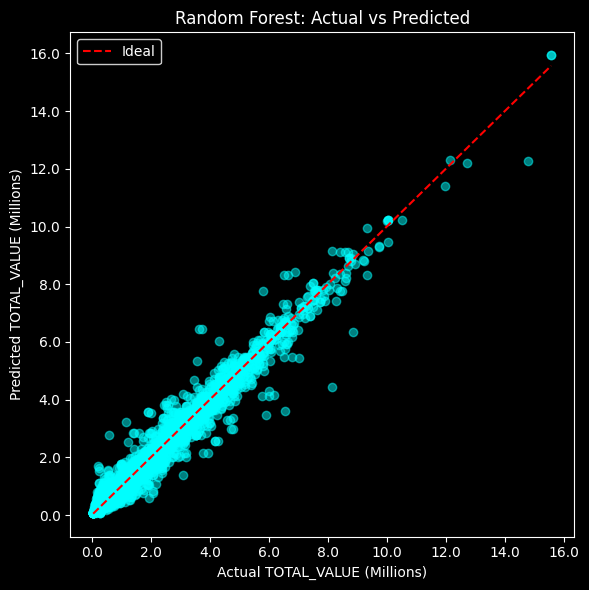

In [15]:
import matplotlib.ticker as mticker
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6), facecolor='black')
ax = plt.gca()
ax.set_facecolor('black')

plt.scatter(y_test / 1e6, rf_preds / 1e6, alpha=0.5, color='cyan')
plt.plot([y_test.min() / 1e6, y_test.max() / 1e6], [y_test.min() / 1e6, y_test.max() / 1e6], 'r--', label="Ideal")
plt.xlabel("Actual TOTAL_VALUE (Millions)", color='white')
plt.ylabel("Predicted TOTAL_VALUE (Millions)", color='white')
plt.title("Random Forest: Actual vs Predicted", color='white')
plt.legend(facecolor='black', edgecolor='white', labelcolor='white')
ax.tick_params(colors='white')
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_color('white')
ax.spines['top'].set_color('white')
ax.spines['right'].set_color('white')
ax.xaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f'))
ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f'))
plt.tight_layout()
plt.show()